In [170]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [171]:
import torch
import torch.nn as nn

## mLSTM

In [257]:
class mLSTMlayer(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.output_size = output_size
        
        self.linear_q = nn.Linear(input_size, output_size)
        self.linear_k = nn.Linear(input_size, output_size)
        self.linear_v = nn.Linear(input_size, output_size)
        
        self.i_gate = nn.Linear(input_size, output_size)
        self.f_gate = nn.Linear(input_size, output_size)
        self.o_gate = nn.Linear(input_size, output_size)
        
        self.ln = nn.LayerNorm(output_size)
        self.l_n = nn.LayerNorm(output_size)
        
        self.Ct_1 = None
        self.nt_1 = None
    
    def init_states(self, batch_size):
        self.Ct_1 = torch.zeros(batch_size, self.output_size)
        self.nt_1 = torch.zeros(batch_size, self.output_size)
    
    def forward(self, x):
        it = torch.exp(self.i_gate(x))
        ft = torch.exp(self.f_gate(x)) # or torch.sigmoid(f_gate(x))
        ot = torch.sigmoid(self.o_gate(x))
        
        qt = self.linear_q(x)
        kt = self.linear_k(x) # add 1/sqrt(d)
        vt = self.linear_v(x)
        
        Ct_1 = torch.zeros(x.shape[0], self.output_size) if self.Ct_1 is None else self.Ct_1
        Ct = ft * Ct_1  +  it * vt * kt
        Ct = self.ln(Ct)
        self.Ct_1 = Ct.detach()
        
        nt_1 = torch.zeros(x.shape[0], self.output_size) if self.nt_1 is None else self.Ct_1
        nt = ft * nt_1 + it * kt
        nt = self.l_n(nt)
        self.nt_1 = nt.detach()
        
        ht = ot * ( Ct*qt / torch.max(abs(nt*qt)) )
        
        return ht

## sLSTM

In [258]:
class sLSTMlayer(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.output_size = output_size
        
        self.i_gate = nn.Linear(input_size, output_size, bias=False)
        self.f_gate = nn.Linear(input_size, output_size, bias=False)
        self.o_gate = nn.Linear(input_size, output_size, bias=False)
        self.z_gate = nn.Linear(input_size, output_size, bias=False)

        self.ri_gate = nn.Linear(output_size, output_size)
        self.rf_gate = nn.Linear(output_size, output_size)
        self.ro_gate = nn.Linear(output_size, output_size)
        self.rz_gate = nn.Linear(output_size, output_size)
        
        self.ln = nn.LayerNorm(output_size)
        self.l_n = nn.LayerNorm(output_size)
        self.ln_h = nn.LayerNorm(output_size)
        
        self.ct_1 = None
        self.nt_1 = None
        self.ht_1 = None
    
    def init_states(self, batch_size):
        self.ct_1 = torch.zeros(batch_size, self.output_size)
        self.nt_1 = torch.zeros(batch_size, self.output_size)
        self.ht_1 = torch.zeros(batch_size, self.output_size)
    
    def forward(self, x):
        ht_1 = torch.zeros(x.shape[0], self.output_size) if self.ht_1 is None else self.ht_1
        
        it = torch.exp(self.i_gate(x) + self.ri_gate(ht_1))
        ft = torch.exp(self.f_gate(x) + self.rf_gate(ht_1))
        ot = torch.sigmoid(self.o_gate(x) + self.ro_gate(ht_1))
        zt = torch.tanh(self.z_gate(x) + self.rz_gate(ht_1))
        
        ct_1 = torch.zeros(x.shape[0], self.output_size) if self.ct_1 is None else self.ct_1
        ct = ft*ct_1 + it*zt
        ct = self.ln(ct)
        self.ct_1 = ct.detach()
        
        nt_1 = torch.zeros(x.shape[0], self.output_size) if self.nt_1 is None else self.nt_1
        nt = ft*nt_1 + it
        nt = self.l_n(nt)
        self.nt_1 = nt.detach()
        
        ht = ot * (ct/nt)
        ht = self.ln_h(ht)
        self.ht_1 = ht.detach()
        return ht
        

# Test

In [263]:
class TestModel(nn.Module):
    def __init__(self, type_, config=[2, 3, 1]):
        super().__init__()
        self.type = type_
        self.config = config

        if self.type == "mlstm":
            self.model = nn.Sequential(*[mLSTMlayer(self.config[dim], self.config[dim+1]) for dim in range(len(self.config)-2)])
        else:
            self.model = nn.Sequential(*[sLSTMlayer(self.config[dim], self.config[dim+1]) for dim in range(len(self.config)-2)])
        
        self.head = nn.Linear(self.config[len(config)-2], self.config[len(config)-1])
        self.drop = nn.Dropout(0.2)
        
    def init_states(self, batch_size):
        for b in self.model:
            b.init_states(batch_size)
            
    def forward(self, x):
        x = torch.relu(self.drop(self.model(x)))
        x = torch.sigmoid(self.head(x))
        return x

In [196]:
!kaggle datasets download -d tarunpaparaju/apple-aapl-historical-stock-data

Dataset URL: https://www.kaggle.com/datasets/tarunpaparaju/apple-aapl-historical-stock-data
License(s): CC0-1.0
  0%|                                               | 0.00/49.5k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 49.5k/49.5k [00:00<00:00, 2.58MB/s]


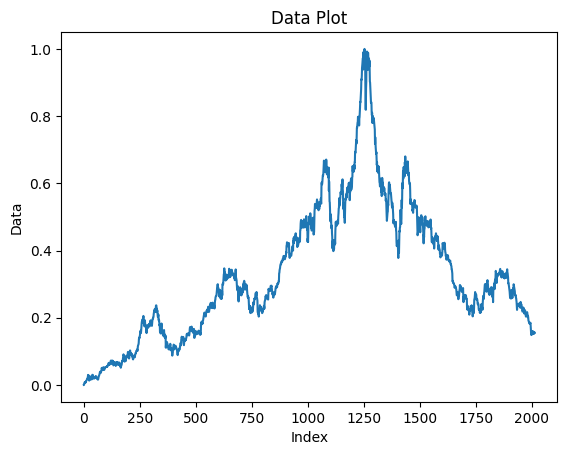

In [213]:
import pandas as pd
df = pd.read_csv("/kaggle/working/apple-aapl-historical-stock-data.zip")
data = df.reset_index()[' Close/Last'] # Make sure to include a space
df3 = data.reindex(index=data.index[::-1])
df3.head()

df2 = []
#constructing a new list
for i in data: 
    i = i[2:]
    i = float(i)
    df2.append(i)
    #Reversing the list
    df2.reverse()
#Creating a new dataframe
df1 = pd.DataFrame(df2)[0]


import numpy as np 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
from sklearn.model_selection import train_test_split
#Setting shuffle to False
X_train, X_test = train_test_split(df1, test_size=0.20, shuffle=False)

plt.title("Data Plot")
plt.xlabel("Index")
plt.ylabel("Data")
plt.plot(X_train)

In [227]:
data_x = torch.from_numpy(X_train)
data_val = torch.from_numpy(X_test)
data_val.shape

torch.Size([504, 1])

In [260]:
from tqdm.auto import tqdm

In [264]:
block_size = 16
model = TestModel("mlstm", config=[block_size, 100, 100, 100, 1])


optim = torch.optim.AdamW(model.parameters(), lr=0.0004)
loss_fn = nn.MSELoss()

for epoch in tqdm(range(2)):
    for iter in tqdm(range(data_x.shape[0]-block_size-1)):
        x = data_x[iter:iter+block_size].view(1, block_size).float()
        y = data_x[iter+block_size+1].view(1, 1).float()

        out = model(x)
        loss = nn.MSELoss()(out, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        if iter % 100 == 0:
            model.init_states(x.shape[0])
            print(loss)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1997 [00:00<?, ?it/s]

tensor(0.2279, grad_fn=<MseLossBackward0>)
tensor(0.0524, grad_fn=<MseLossBackward0>)
tensor(0.0272, grad_fn=<MseLossBackward0>)
tensor(0.0047, grad_fn=<MseLossBackward0>)
tensor(0.0156, grad_fn=<MseLossBackward0>)
tensor(2.4155e-05, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(5.3947e-06, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0163, grad_fn=<MseLossBackward0>)
tensor(0.0229, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0274, grad_fn=<MseLossBackward0>)
tensor(0.0034, grad_fn=<MseLossBackward0>)
tensor(0.0076, grad_fn=<MseLossBackward0>)
tensor(6.4439e-05, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)


  0%|          | 0/1997 [00:00<?, ?it/s]

tensor(0.0185, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(7.4670e-05, grad_fn=<MseLossBackward0>)
tensor(0.0055, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0016, grad_fn=<MseLossBackward0>)
tensor(0.0188, grad_fn=<MseLossBackward0>)
tensor(0.0484, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0045, grad_fn=<MseLossBackward0>)
tensor(0.0110, grad_fn=<MseLossBackward0>)
tensor(0.0116, grad_fn=<MseLossBackward0>)
tensor(0.0035, grad_fn=<MseLossBackward0>)
tensor(0.0049, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)


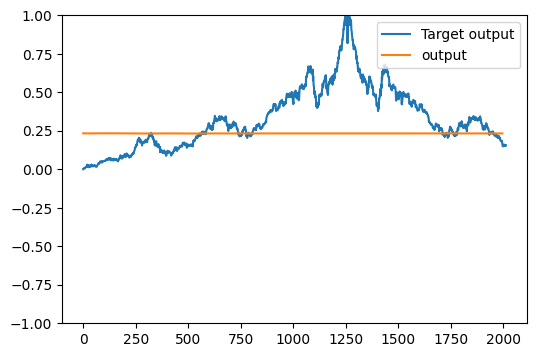

In [262]:
with torch.no_grad():
    out = []
    for iter in tqdm(range(data_x.shape[0]-block_size-1)):
        x = data_x[iter:iter+block_size].view(1, block_size).float()
        o = model(x)
        out.append(o)
out = torch.stack(out, dim=0).squeeze(2)

plt.figure(figsize=(6, 4))
plt.plot(data_x[:, 0], label="Target output")
plt.plot(out[:, 0], label="output")
plt.ylim((-1, 1))
plt.legend(loc="upper right")
plt.show()